In [1]:
import warnings
notebook_warnings = []
def warning_collector(message, category, filename, lineno, file=None, line=None):
    notebook_warnings.append(f"{category.__name__}: {message} (File {filename}, line {lineno})")
warnings.showwarning = warning_collector


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2021 - 2022 United Kingdom Research and Innovation
#  Copyright 2021 - 2022 The University of Manchester
#  Copyright 2021 - 2022 The Karlsruhe Institute of Technology
#  Copyright 2021 - 2022 Technical University of Denmark 
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Evelina Ametova (KIT)
#                   Jakob S. Jørgensen (DTU)
#                   Gemma Fardell (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)

# CT data preprocessing

Sometimes we are lucky to have a (simulated) dataset which is ready to reconstruct. However sometimes we get raw data which we need to preprocess first to get sensible reconstruction.
CIL provides a number of useful image manipulation tools - processors. 
In this notebook we will demonstrate some of them.

## Learning objectives:
- Read in and manipulate data
- Compensate for centre-of-rotation offset
- Slice and bin data
- Remove hot/dead pixels

We start with some imports:

In [3]:
# cil imports
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData

from cil.processors import CentreOfRotationCorrector, Slicer, \
    Binner, Masker, MaskGenerator, TransmissionAbsorptionConverter

from cil.plugins.astra import FBP

from cil.utilities import dataexample
from cil.utilities.display import show2D, show_geometry


# External imports
import numpy as np
import matplotlib.pyplot as plt
import logging

In [4]:
# Set logging level for CIL processors:
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.INFO)

In [5]:
# set up default colour map for visualisation
cmap = "gray"

## Loading dataset

We use the steel-wire dataset from the Diamond Light Source (DLS). The dataset is included in CIL for demonstration purposes and can be loaded as:

In [6]:
# Set up a reader object pointing to the Nexus data set
data_raw = dataexample.SYNCHROTRON_PARALLEL_BEAM_DATA.get()

We load not only the data array itself, but also its corresponding metadata, i.e. `AcquisitionGeometry`:

In [7]:
print(data_raw)

Number of dimensions: 3
Shape: (91, 135, 160)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



In [8]:
print(data_raw.geometry)

3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [0., 0., 0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [160 135]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 91
	Angles 0-9 in degrees: [-88.2   , -86.2   , -84.2001, -82.2   , -80.2   , -78.2   , -76.1999,
 -74.2   , -72.1999, -70.2   ]
	Angles 81-90 in degrees: [73.8   , 75.8   , 77.8   , 79.8   , 81.8   , 83.8   , 85.8   , 87.8   ,
 89.8   , 91.7999]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


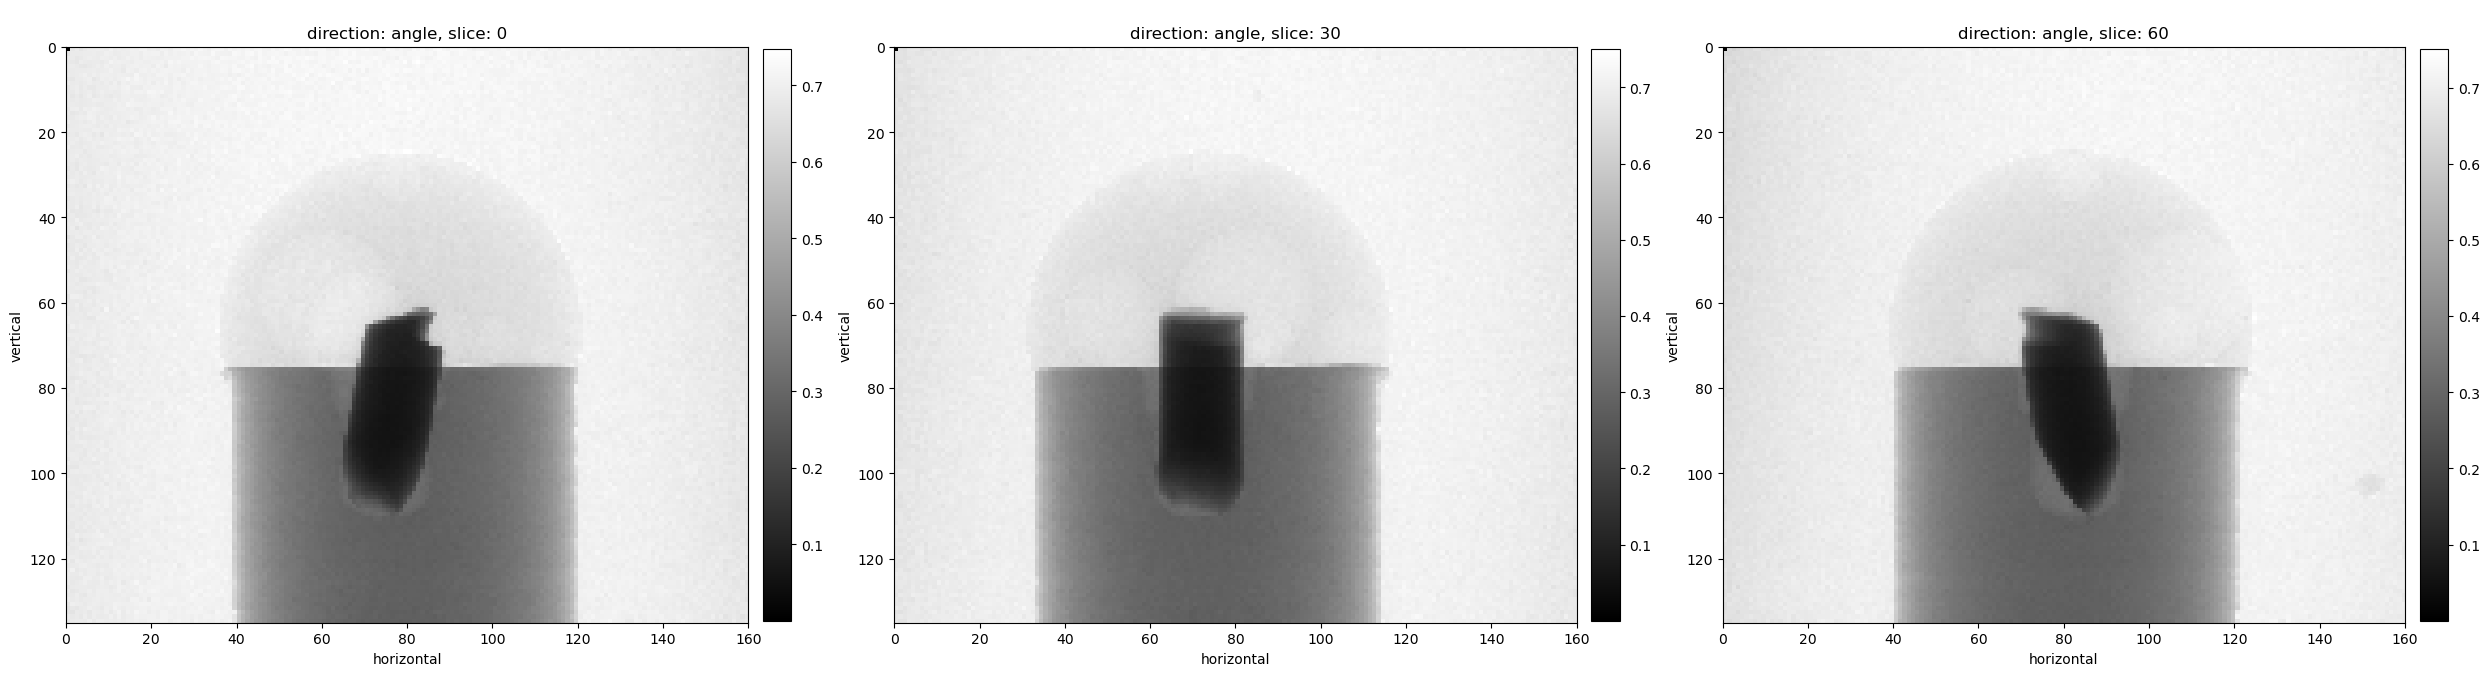

In [9]:
# Visualise data
show2D(data_raw, slice_list=[('angle',0), ('angle', 30), ('angle',60)], \
        cmap=cmap, num_cols=3, size=(25,25), origin='upper-left')

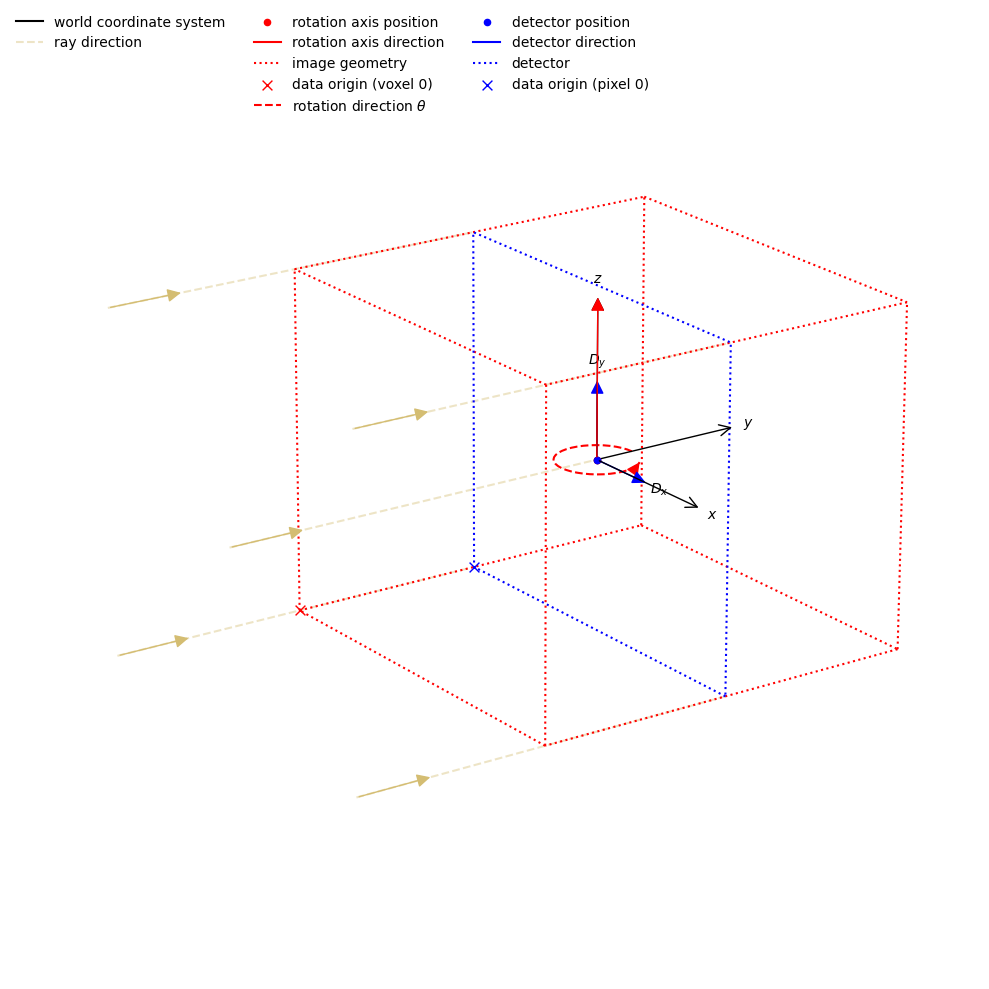

In [10]:
# and show geometry
show_geometry(data_raw.geometry);

You may notice that it looks like our detector is inside our sample!

This is because in the case of parallel beam, the distance between the detector and the sample does not affect our reconstruction, and its distance hasn't been set.

We could update our geometry to set this as follows, where we will see that the detector is no longer inside the sample. The distance we set here doesn't change our reconstruction. However, be careful to set this value correctly in phase contrast experiments if you intend to use phase retrieval methods, where the propagation distance is important.

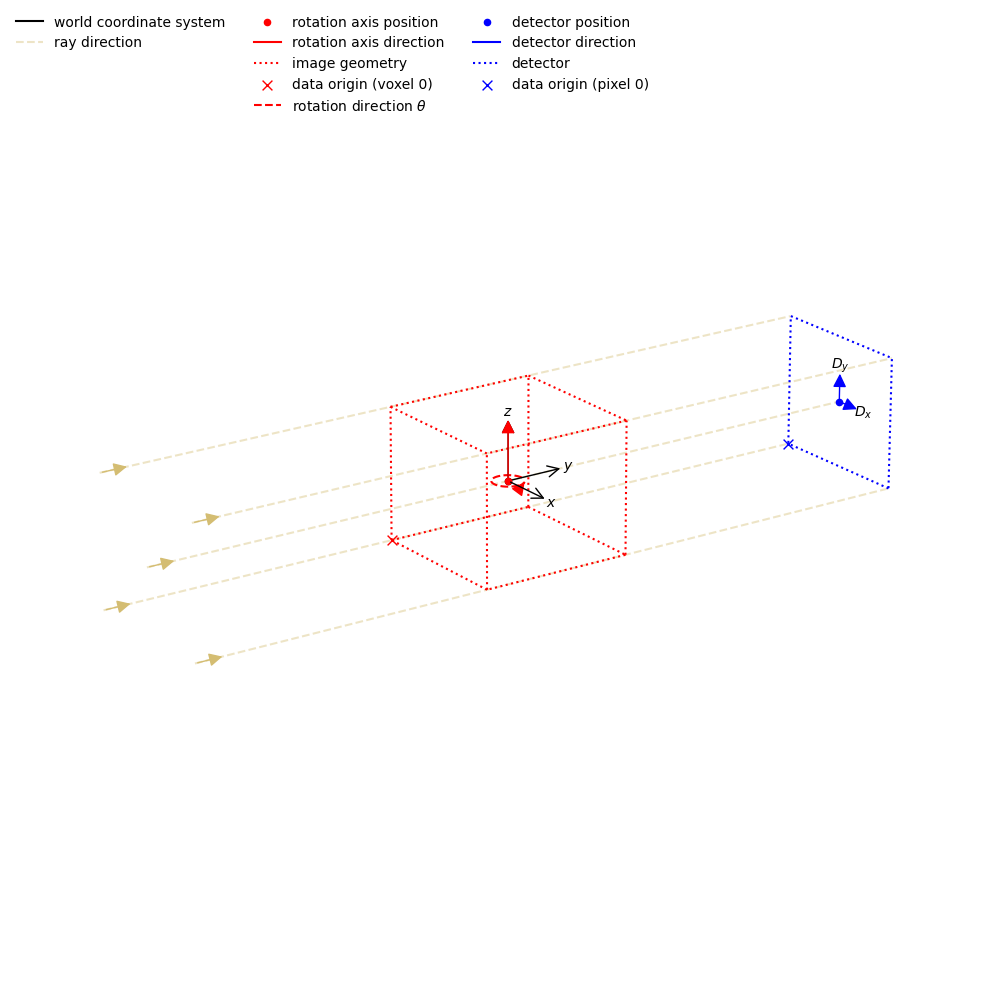

In [11]:
data_raw.geometry.config.system.detector.position = [0, 400, 0]

show_geometry(data_raw.geometry);

## Transmission to absorption conversion

From the contrast and background values we can infer that the dataset has already been flat-field corrected. However the background values are less than 1. We simply rescale intensity values by taking the mean of an empty slice and dividing the data array by the mean value.

In [12]:
background = data_raw.get_slice(vertical=20).mean()
data_raw /= background

To convert from transmission contrast to absorption contrast we need to apply a negative logarithm.
We have implemented `TransmissionAbsorptionConverter()` for this.

INFO:cil.processors.TransmissionAbsorptionConverter:
 Current min_intensity = 0.0: output may contain NaN or inf. Ensure your data only contains positive values or set min_intensity to a small positive value.


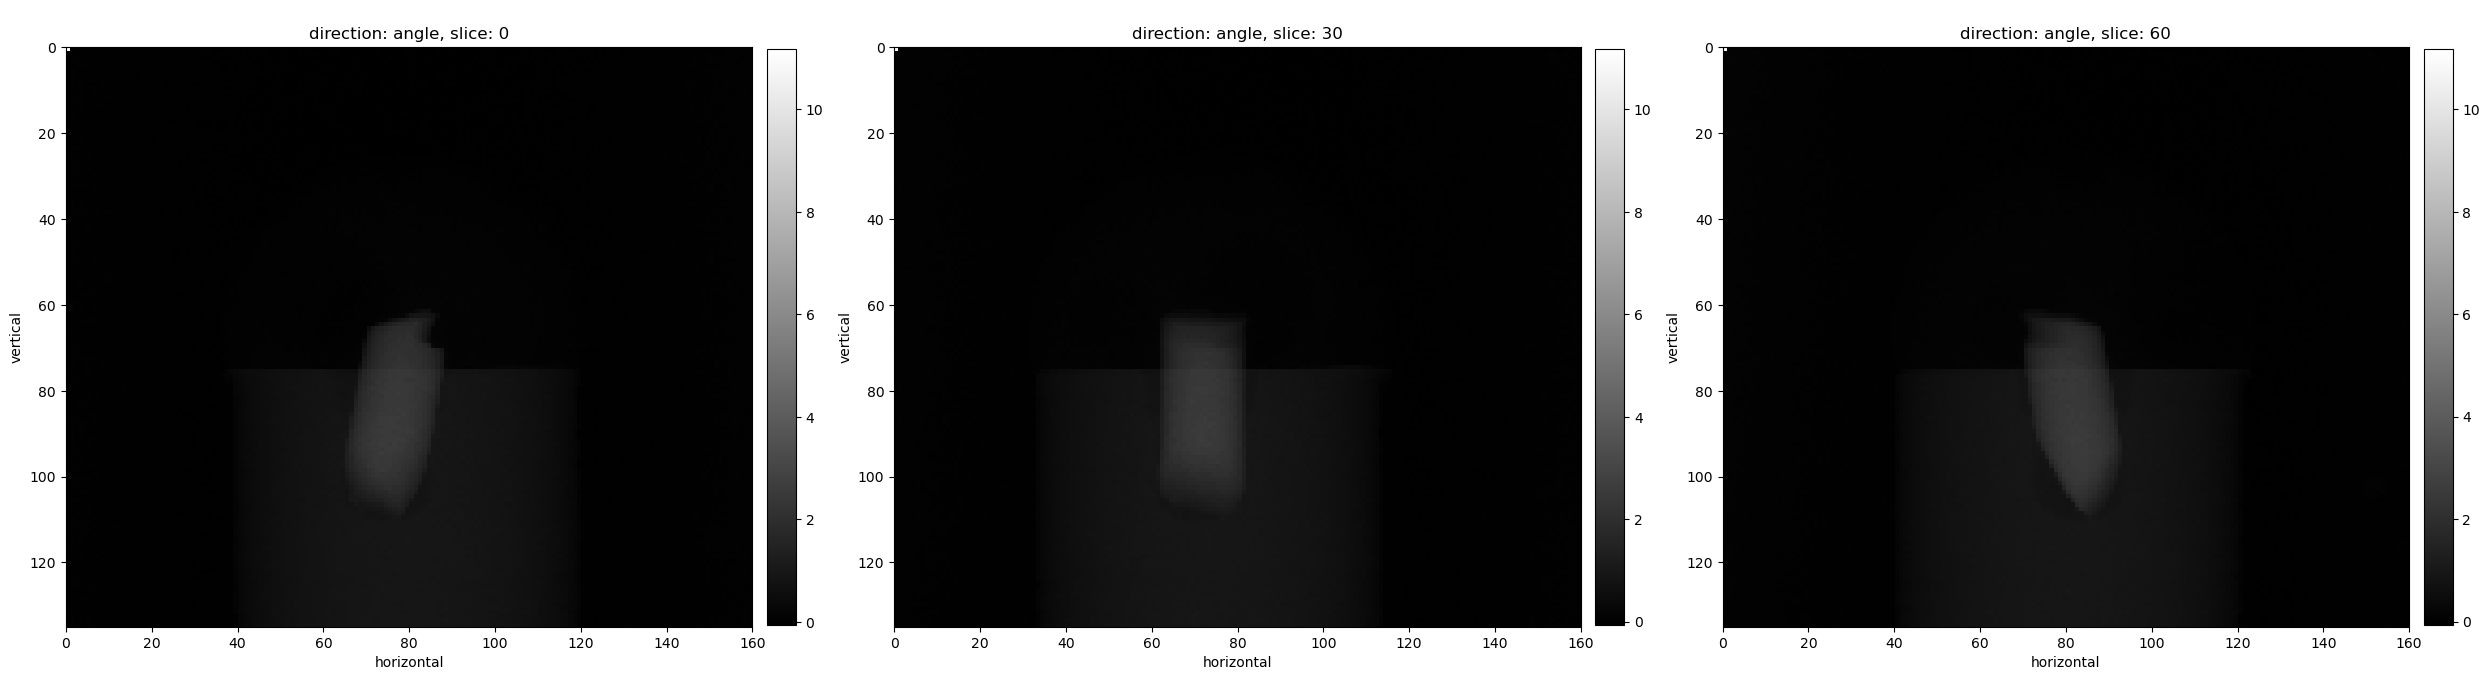

In [13]:
# Convert from transmission to attenuation 
data_exp = TransmissionAbsorptionConverter()(data_raw)
# and plot again
show2D(data_exp, slice_list=[('angle',0), ('angle', 30), ('angle',60)], \
        cmap=cmap, num_cols=3, size=(25,25), origin='upper-left')

The image contrast does not look right. The reason for this is a single dead pixel in the top left corner. Here we zoom in on just the top left 10 by 10 pixels

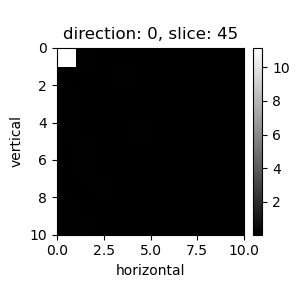

In [14]:
show2D(data_exp.array[:,0:10, 0:10], origin='upper-left', size=(5,5), axis_labels=('horizontal', 'vertical'))

## Removing bad pixels

Dead/stuck/misperforming pixels are a very common problem. Sometimes there are only a few of them and they will be effectively filtered out during reconstruction. However sometimes the flat-field images look like the night sky. Misperforming pixels can significantly impair the reconstructed image quality and are best dealt with as a preprocessing step.

CIL provides processors that can be used to correct these pixels. We'll step through them below but more advanced options will be discussed in the [advanced techniques](#advanced) section of this notebook.

For our wire dataset there are several ways to remove the bright pixel. The simplest is to crop the top slice. As there is only air in this slice anyway there will not be any loss of information.

`Slicer()` is a processor used to slice the data, similar to numpy slicing. To crop the data pass the region of interest parameter `roi`. This is a dictionary where each element defines the behaviour along one dimension. 

To crop along an axis, pass a tuple containing the start index, the end index and step size. `roi={vertical: (index0, index1)}` will crop the data between `index0` and `index1` along the `vertical` dimension. Each of these values can be set to `None` to include all the data i.e., `{vertical: (index0, None)}` will crop the data only on one side. 

New geometry:  3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0. , 400. ,   0.5]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [160 134]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 91
	Angles 0-9 in degrees: [-88.2   , -86.2   , -84.2001, -82.2   , -80.2   , -78.2   , -76.1999,
 -74.2   , -72.1999, -70.2   ]
	Angles 81-90 in degrees: [73.8   , 75.8   , 77.8   , 79.8   , 81.8   , 83.8   , 85.8   , 87.8   ,
 89.8   , 91.7999]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (91, 134, 160)
New geometry shape:  (91, 134, 160)


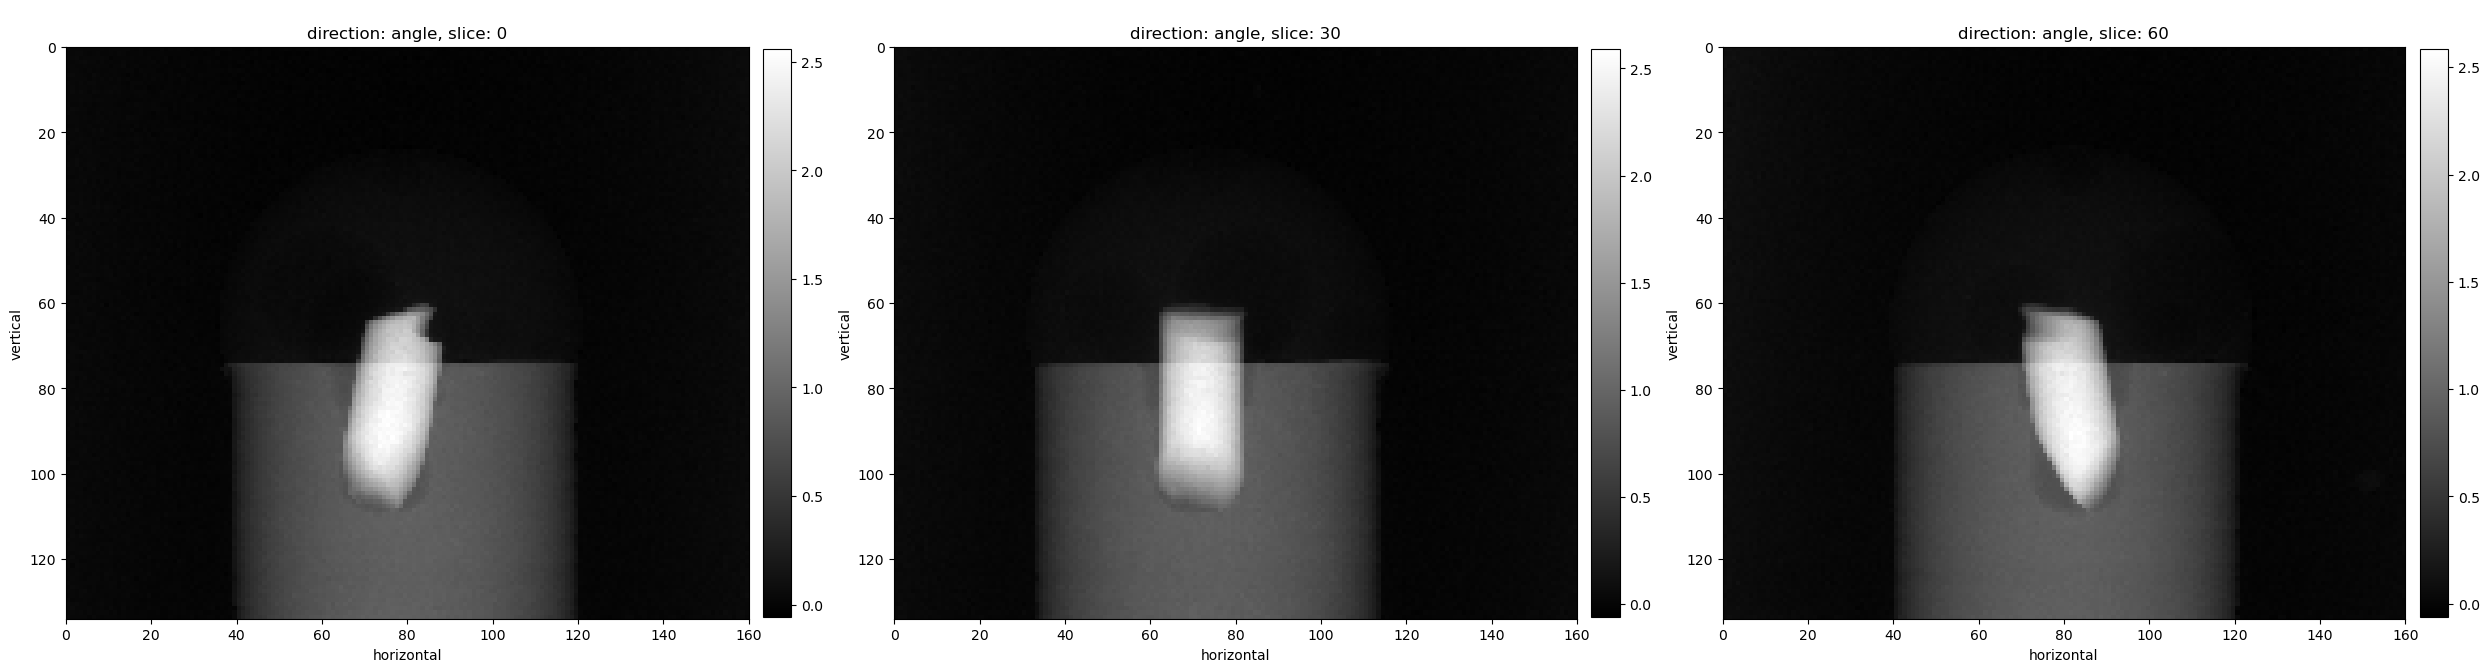

In [15]:
data_crop = Slicer(roi={'vertical': (1, None)})(data_exp)

show2D(data_crop, slice_list=[('angle',0), ('angle', 30), ('angle',60)], \
        cmap=cmap, num_cols=3, size=(25,25), origin='upper-left')

These projections look much better now!

Alternatively we can use a processor for outlier detection. It is called `MaskGenerator()`. 
`MaskGenerator()` is a powerful tool to detect outliers, which was inspired by the MATLAB `rmoutliers`
function. It supports a number of methods including simple threshold and quantiles along with statistical median, mean, moving median and moving mean methods.

In this case, a simple threshold is sufficient.

In [16]:
mask = MaskGenerator.threshold(max_val=10)(data_exp)

Now `mask` is a binary image which contains 0 where outliers were detected and 1 for other pixels. We use `Masker()` to mask out the detected outliers.

In [17]:
data_masked = Masker.interpolate(mask=mask, method='nearest', axis='vertical')(data_exp)

Let's visualise the results:

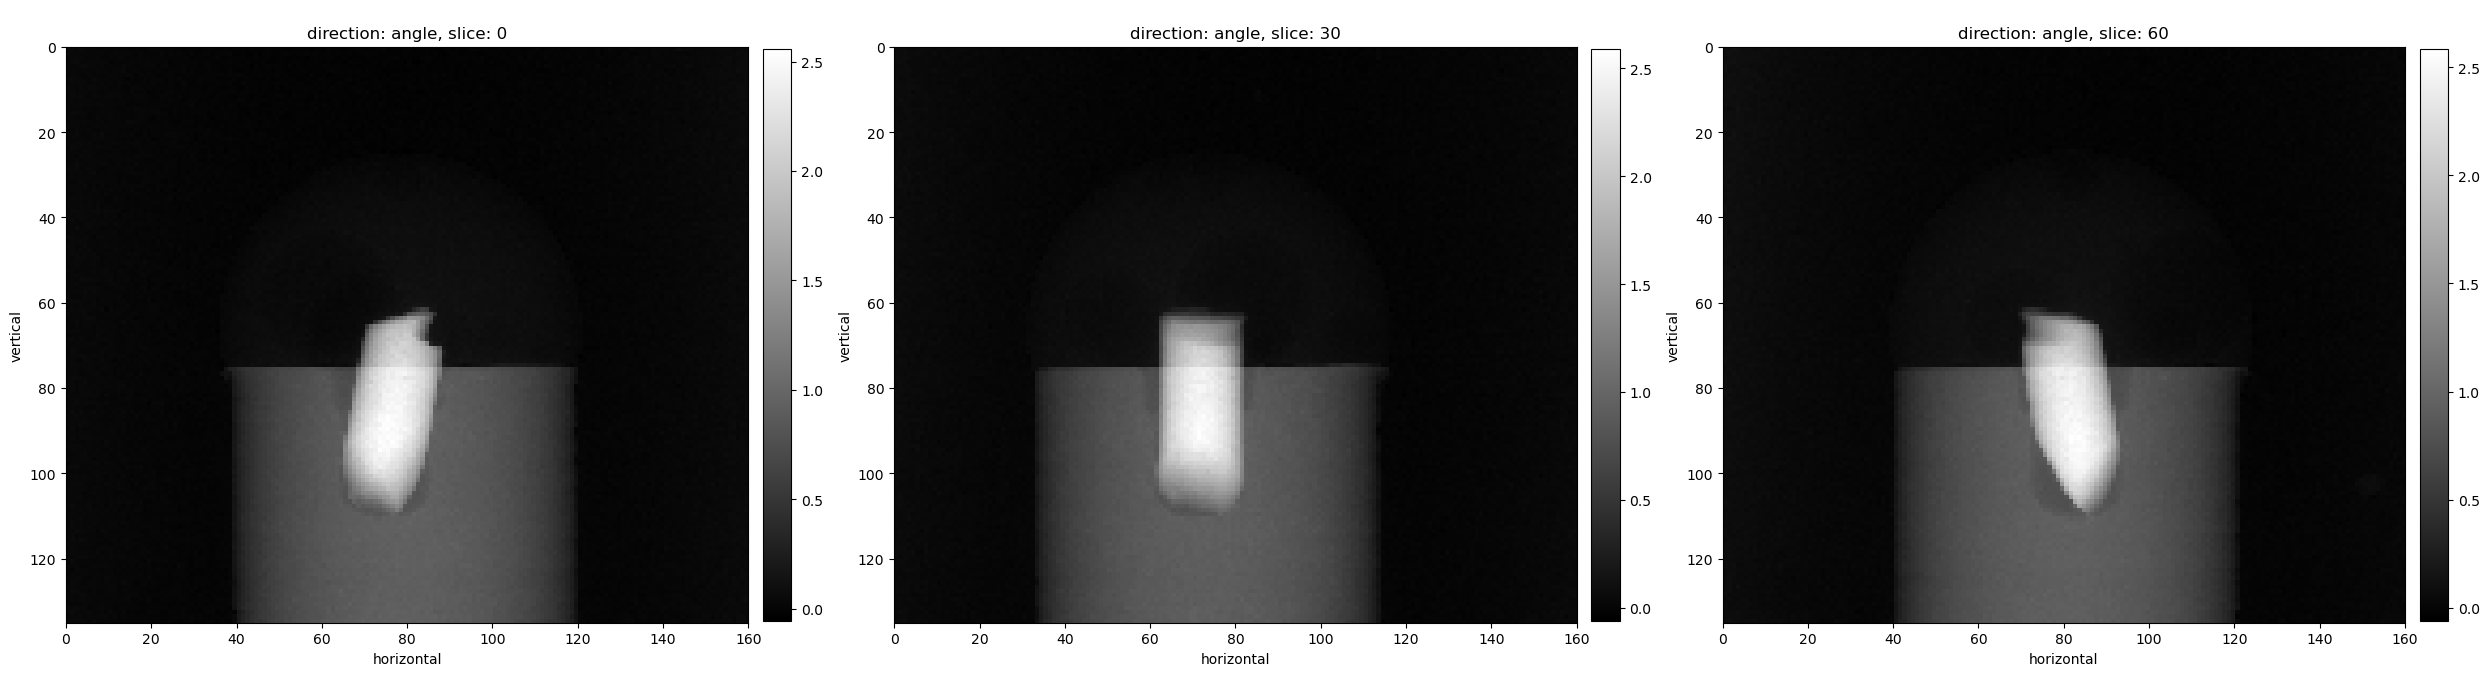

In [18]:
show2D(data_masked, slice_list=[('angle',0), ('angle', 30), ('angle',60)], \
        cmap=cmap, num_cols=3, size=(25,25), origin='upper-left')

Note that `data_crop` and `data_masked` will have different shapes.

In [19]:
print('data_crop shape: {}'.format(data_crop.shape))
print('data_masked shape: {}'.format(data_masked.shape))

data_crop shape: (91, 134, 160)
data_masked shape: (91, 135, 160)


## FBP reconstruction

The next step is to reconstruct the dataset. In this notebook we will use a simple FBP reconstruction. More advanced methods will be discussed in the next notebooks. 

CIL supports different back-ends for which data order conventions may differ. Here we use the FBP algorithm from the ASTRA toolbox plugin.

In 3D geometry the ASTRA toolbox requires the dataset in the form `['vertical','angle','horizontal']`, which doesn't match the DLS dataset. We can reorder the data in place, for use with the ASTRA plugin.

In [20]:
print('old dimension labels: {}'.format(data_crop.dimension_labels))
data_crop.reorder(order='astra')
print('new dimension labels: {}'.format(data_crop.dimension_labels))

old dimension labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)
new dimension labels: (<AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)


Now we are ready to run FBP reconstruction. Remember, reconstruction requires `ImageGeometry` and `AcquisitionGeometry`. `data_crop` contains the dataset itself along with all metadata.

In [21]:
# get acquisition geometry
ag = data_crop.geometry

Here we use a default `ImageGeometry` calculated from the `AcquisitionGeometry`. `ImageGeometry` can be modified to reconstruct on a coarser/finer grid or perform ROI reconstruction.

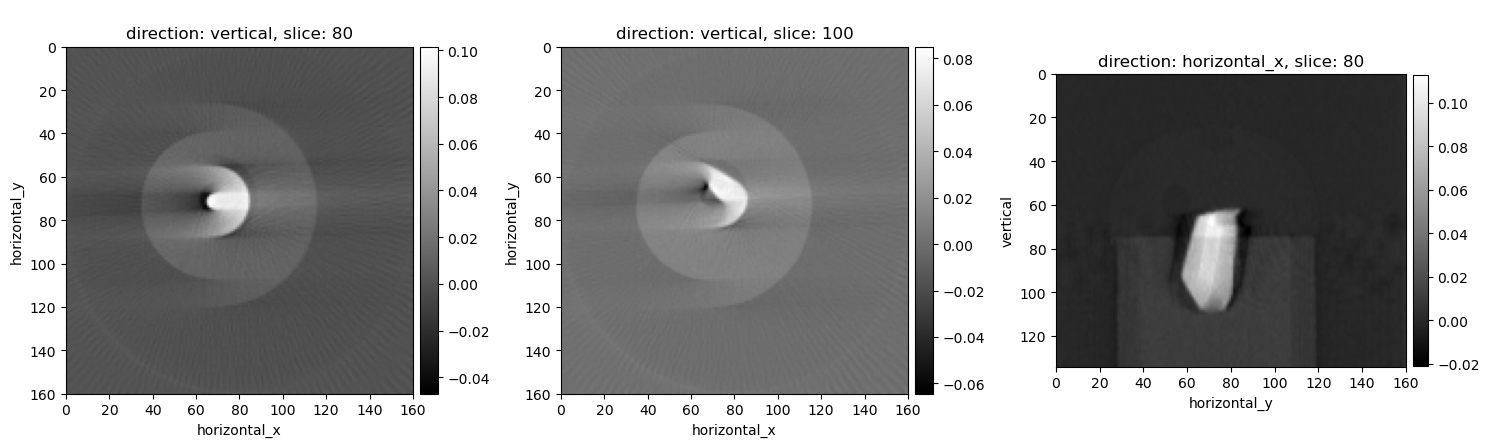

In [22]:
# Create image geometry
ig = ag.get_ImageGeometry()

fbp_recon = FBP(ig, ag, device='gpu')(data_crop)

# visualise reconstruction results
show2D(fbp_recon, slice_list=[('vertical',80), ('vertical',100), ('horizontal_x',80)], \
        cmap=cmap, num_cols=3, size=(15,15), origin='upper-left')

We can see that the reconstructed slices do not look good. If you have ever looked at CT data you will probably recognise that there is an offset in the centre of rotation.

## Centre of Rotation correction

In a well aligned CT system, the axis of rotation is perpendicular to the X-ray beam and the rows of detector pixels. The centre of rotation is the projection of the axis of rotation on to the detector. The reconstruction assumes this is horizontally centred on the detector. An offset introduces blurring and artefacts in the reconstruction.

There are various ways to estimate the centre of rotation offset. For the parallel geometry case we can use cross-correlation between 0 and 180 degrees. CIL provides a processor which implements this method.

In [23]:
data_centred = CentreOfRotationCorrector.xcorrelation()(data_crop)

INFO:cil.processors.CofR_xcorrelation:Centre of rotation correction found using cross-correlation


INFO:cil.processors.CofR_xcorrelation:Calculated from slice: centre


INFO:cil.processors.CofR_xcorrelation:Centre of rotation shift = 6.370000 pixels


INFO:cil.processors.CofR_xcorrelation:Centre of rotation shift = 6.370000 units at the object


INFO:cil.processors.CofR_xcorrelation:Return new dataset with centred geometry


Note, that `CentreOfRotationCorrector` doesn't modify the dataset but updates the corresponding geometry.

In [24]:
print('data_crop rotation axis position: {}'.format(data_crop.geometry.config.system.rotation_axis.position))
print('data_centred rotation axis position: {}'.format(data_centred.geometry.config.system.rotation_axis.position))

data_crop rotation axis position: [0. 0. 0.]
data_centred rotation axis position: [6.37 0.   0.  ]


We use the `show_geometry` utility to illustrate `AcquisitionGeometry` before and after the correction. Note, after the correction the rotation axis position and the detector positon do not coincide anymore.

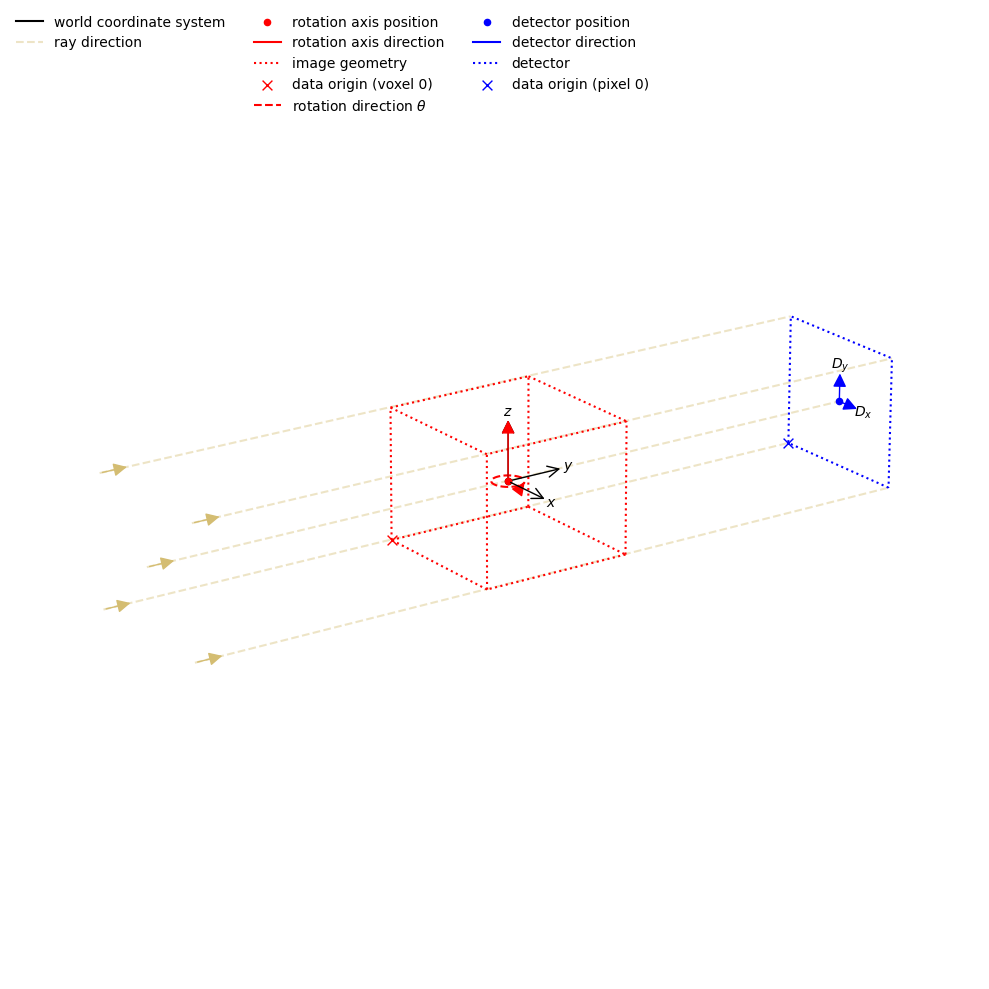

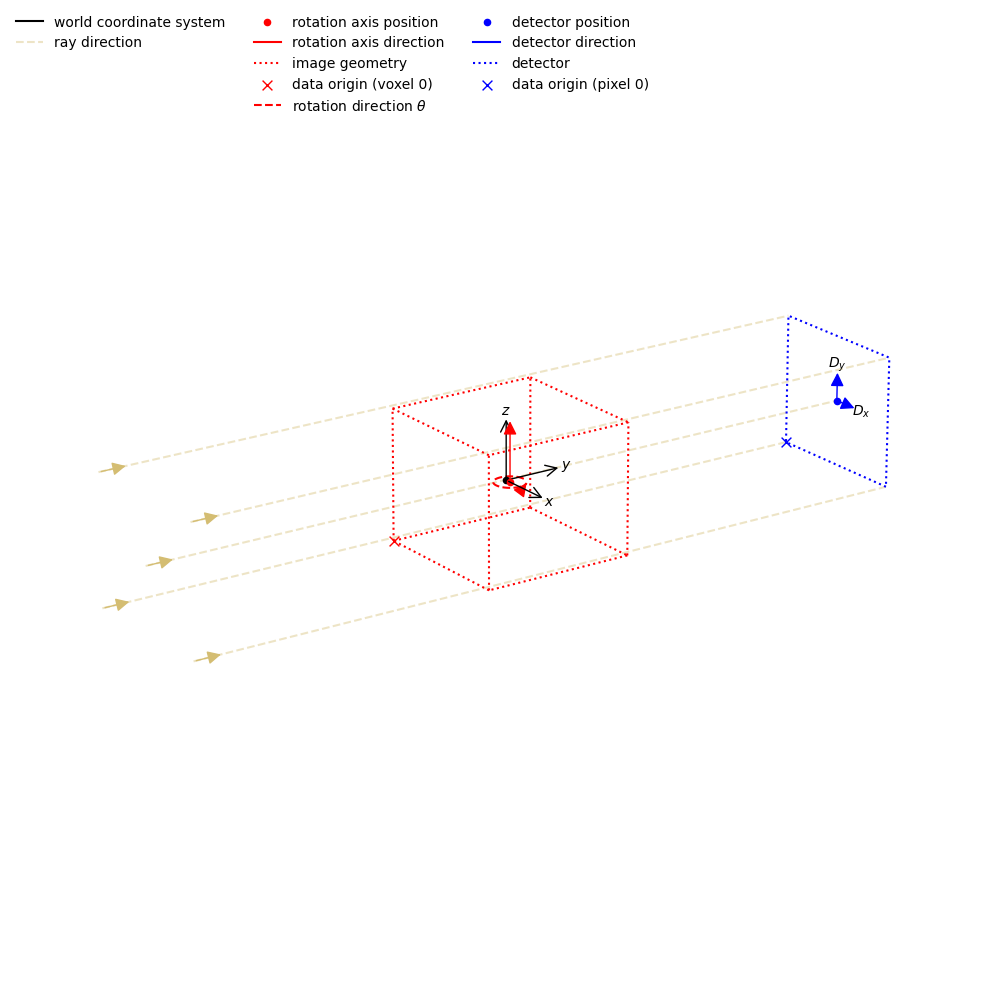

In [25]:
show_geometry(data_crop.geometry)
show_geometry(data_centred.geometry)

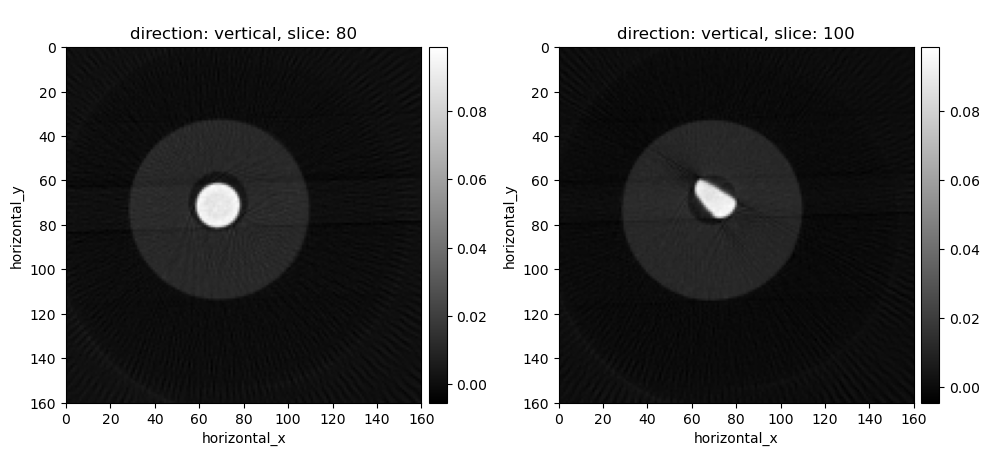

In [26]:
# get acquisition geometry
ag_centred = data_centred.geometry

# FBP reconstruction
fbp_recon_centred = FBP(ig, ag_centred, device='gpu')(data_centred)

# visualize reconstruction results
show2D(fbp_recon_centred,  slice_list = [('vertical',80), ('vertical', 100) ], \
        cmap=cmap, num_cols=3, size=(10,10), origin='upper-left')

## Slicing and binning data

The data contains a redundant projection at 180 degrees, which can be discarded by keeping only the 90 angles.

We could also crop both sides of the image to remove pixels that only see air. We want to keep only horizontal pixels from 20 to 140 out of 160.

Both of these can be done in the same operation by using the `Slicer` Processor. This processor modifies both the data and the corresponding geometry and the trimmed data is printed, showing the horizontal dimension now reduced to 120. Note that `Slicer` supports negative indexing.

In [27]:
data_centred = Slicer(roi={'angle':(0,90), 'horizontal':(20,-20,1)})(data_centred)
print(data_centred)

New geometry:  3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [6.37, 0.  , 0.  ]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0. , 400. ,   0.5]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [120 134]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 90
	Angles 0-9 in degrees: [-88.2   , -86.2   , -84.2001, -82.2   , -80.2   , -78.2   , -76.1999,
 -74.2   , -72.1999, -70.2   ]
	Angles 80-89 in degrees: [71.8, 73.8, 75.8, 77.8, 79.8, 81.8, 83.8, 85.8, 87.8, 89.8]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (134, 90, 120)
New geometry shape:  (134, 90, 120)
Number of dimensions: 3
Shape: (134, 90, 120)
Axis labels: (<AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.ANG

Quite often we want to test methods with a lower number of projections. `Slicer` can be used to skip projections. Here we will use `Slicer` to generate new datasets with a lower number of projections. To speed up reconstruction, we will work only with a single slice. Note, dimension labels refer to different dimensions therefore we can conveniently use the `get_slice` method to extract a single slice along the corresponding dimension.

We create a new 2D dataset from a single slice of the 3D data, and create a corresponding 2D `ImageGeometry`:

In [28]:
# get single slice
data_slice = data_centred.get_slice(vertical=100)
# and corresponding geometry
ig_slice = data_slice.geometry.get_ImageGeometry()

As you can see, the new acquisition geometry is already configured for us:

In [29]:
print(data_slice.geometry)

2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0., 0.]
	Detector position: [ -6.37, 400.  ]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [120   1]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 90
	Angles 0-9 in degrees: [-88.2   , -86.2   , -84.2001, -82.2   , -80.2   , -78.2   , -76.1999,
 -74.2   , -72.1999, -70.2   ]
	Angles 80-89 in degrees: [71.8, 73.8, 75.8, 77.8, 79.8, 81.8, 83.8, 85.8, 87.8, 89.8]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


Here we will create 6 datasets each with fewer angles, and reconstruct each one:

In [30]:
step_list = [1,2,3,4,5,6]
titles = []
results = []

for step in step_list:
   
    #slice acquisition data
    data_sliced = Slicer(roi={'angle': (None, None, step)})(data_slice)

    #Perform a fast reconstruction of the slice using FBP
    FBP_output = FBP(ig_slice, data_sliced.geometry, device='gpu')(data_sliced)

    #save the results
    titles.append("# projections {}".format(data_sliced.shape[0]))
    results.append(FBP_output)

New geometry:  2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0., 0.]
	Detector position: [ -6.37, 400.  ]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [120   1]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 90
	Angles 0-9 in degrees: [-88.2   , -86.2   , -84.2001, -82.2   , -80.2   , -78.2   , -76.1999,
 -74.2   , -72.1999, -70.2   ]
	Angles 80-89 in degrees: [71.8, 73.8, 75.8, 77.8, 79.8, 81.8, 83.8, 85.8, 87.8, 89.8]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (90, 120)
New geometry shape:  (90, 120)
New geometry:  2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0., 0.]
	Detector position: [ -6.37, 400.  ]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [120 

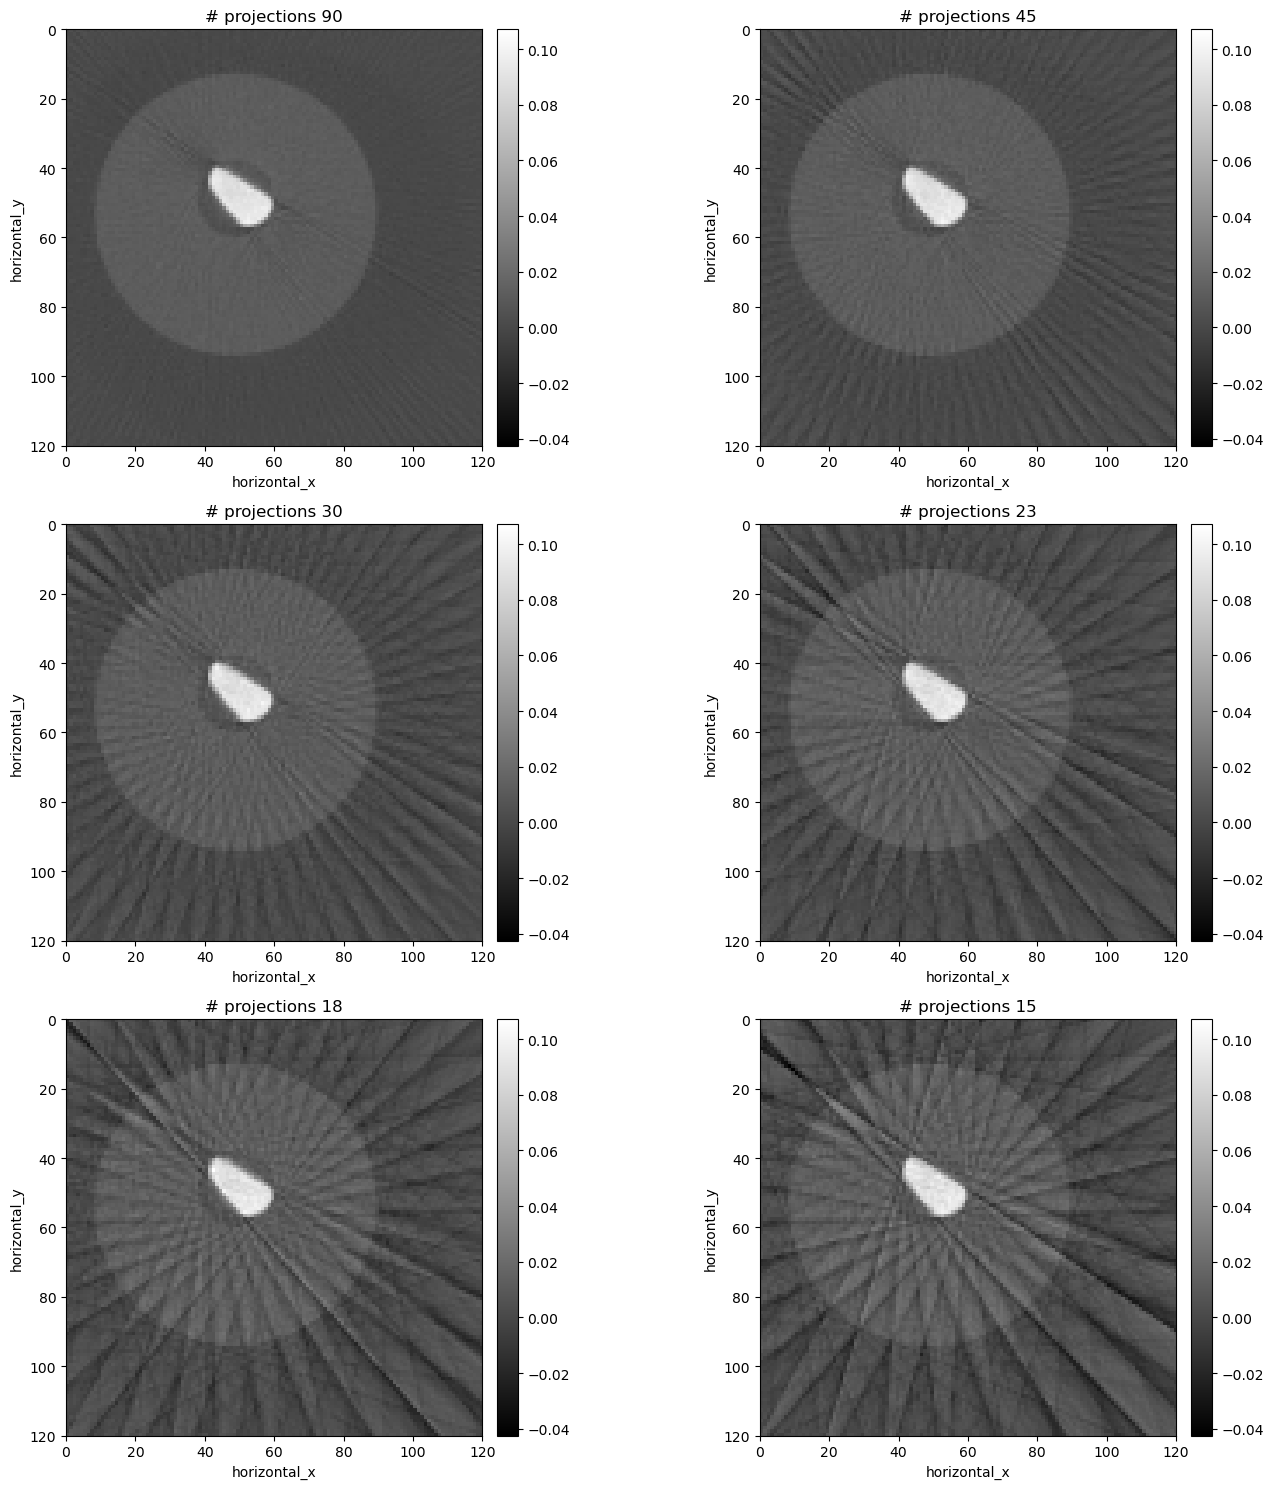

In [31]:
#plot the results    
show2D(results, titles, fix_range=True, cmap=cmap, origin='upper-left')

We might also want to bin the data. Instead of picking out values we may want to average data together. CIL provides a `Binner` processor to do this. 

It is used in a similar way to `Slicer` but instead of skipping elements, it calculates their average. For instance, `Binner(roi={horizontal: (None, None,2)})` will calculate the average of every 2 elements along horizontal axis.

This is demonstrated below, with the acquisition data with 2x binning.

New geometry:  2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0., 0.]
	Detector position: [ -6.37, 400.  ]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [60  1]
	Pixel size: [2. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 90
	Angles 0-9 in degrees: [-88.2   , -86.2   , -84.2001, -82.2   , -80.2   , -78.2   , -76.1999,
 -74.2   , -72.1999, -70.2   ]
	Angles 80-89 in degrees: [71.8, 73.8, 75.8, 77.8, 79.8, 81.8, 83.8, 85.8, 87.8, 89.8]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (90, 60)
New geometry shape:  (90, 60)


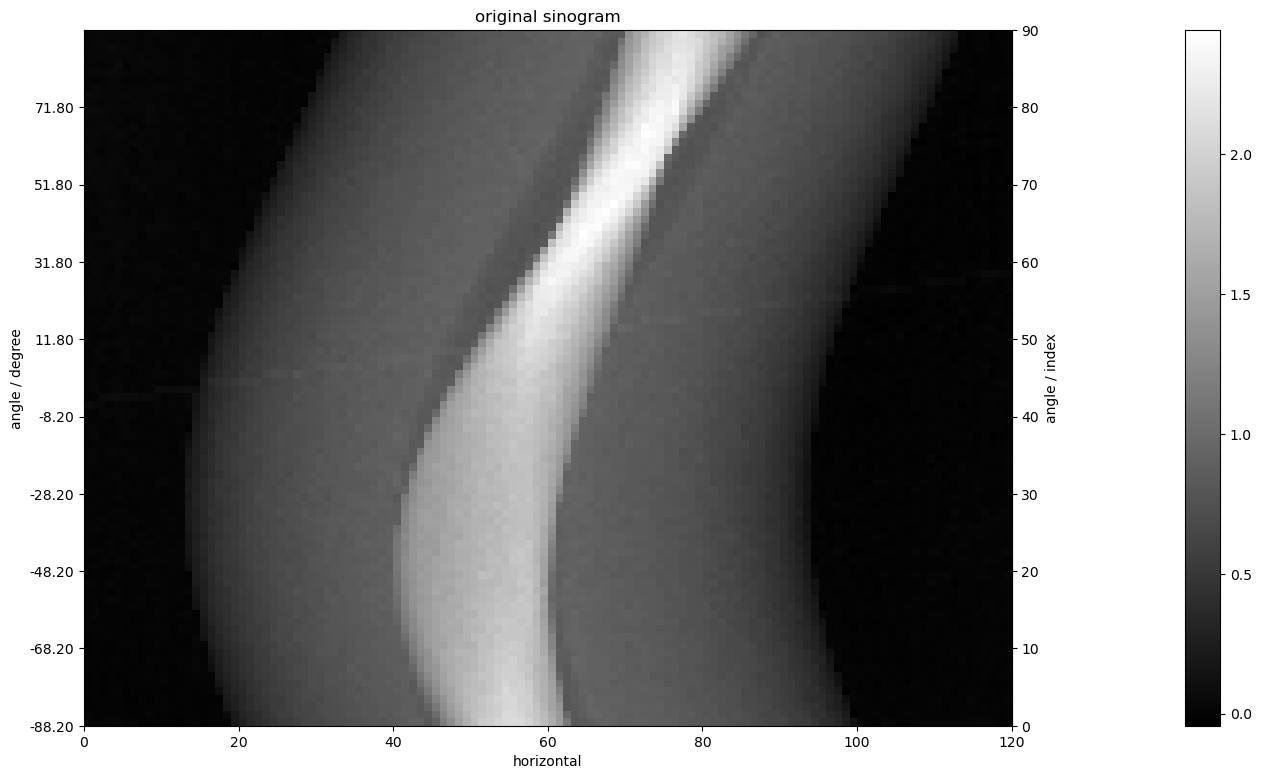

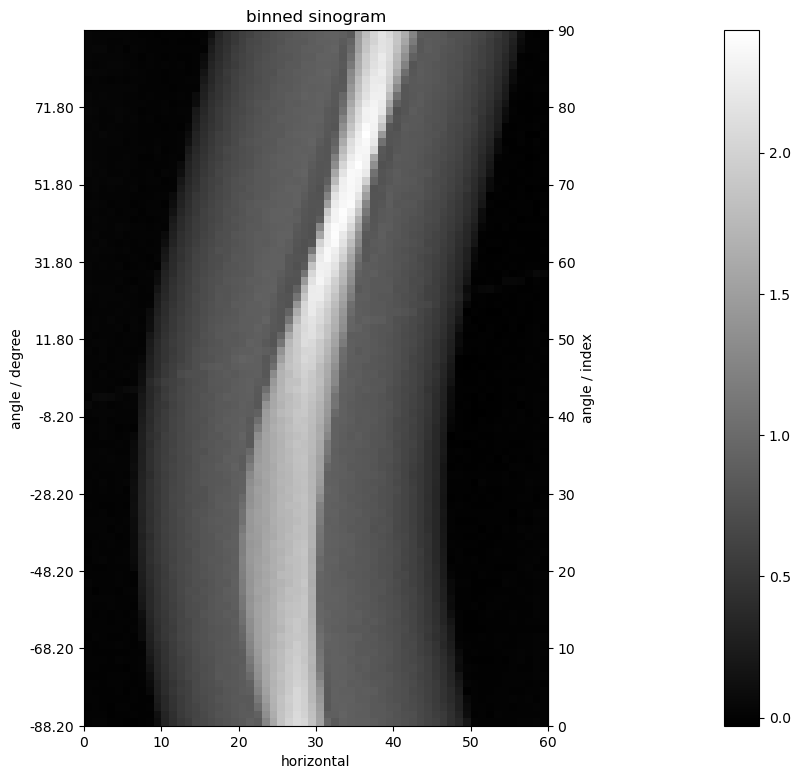

In [32]:
data_binned = Binner(roi={'horizontal': (None, None, 2)})(data_slice)
show2D(data_slice, "original sinogram", fix_range=True, cmap=cmap)
show2D(data_binned, "binned sinogram", fix_range=True, cmap=cmap)


Now we will create 4 new datasets with increasing binning to see the effect binning the acquisition data has on the reconstructed volume.

We bin the `AcquisitionData` but maintain the original `ImageData` with the original 120x120 resolution. This means the reconstructed slice contains the same number of voxels as before, but the spatial resolution of the reconstruction will degrade.

New geometry:  2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0., 0.]
	Detector position: [ -6.37, 400.  ]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [120   1]
	Pixel size: [1. 1.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 90
	Angles 0-9 in degrees: [-88.2   , -86.2   , -84.2001, -82.2   , -80.2   , -78.2   , -76.1999,
 -74.2   , -72.1999, -70.2   ]
	Angles 80-89 in degrees: [71.8, 73.8, 75.8, 77.8, 79.8, 81.8, 83.8, 85.8, 87.8, 89.8]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (90, 120)
New geometry shape:  (90, 120)
New geometry:  2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0., 0.]
	Detector position: [ -6.37, 400.  ]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [60  

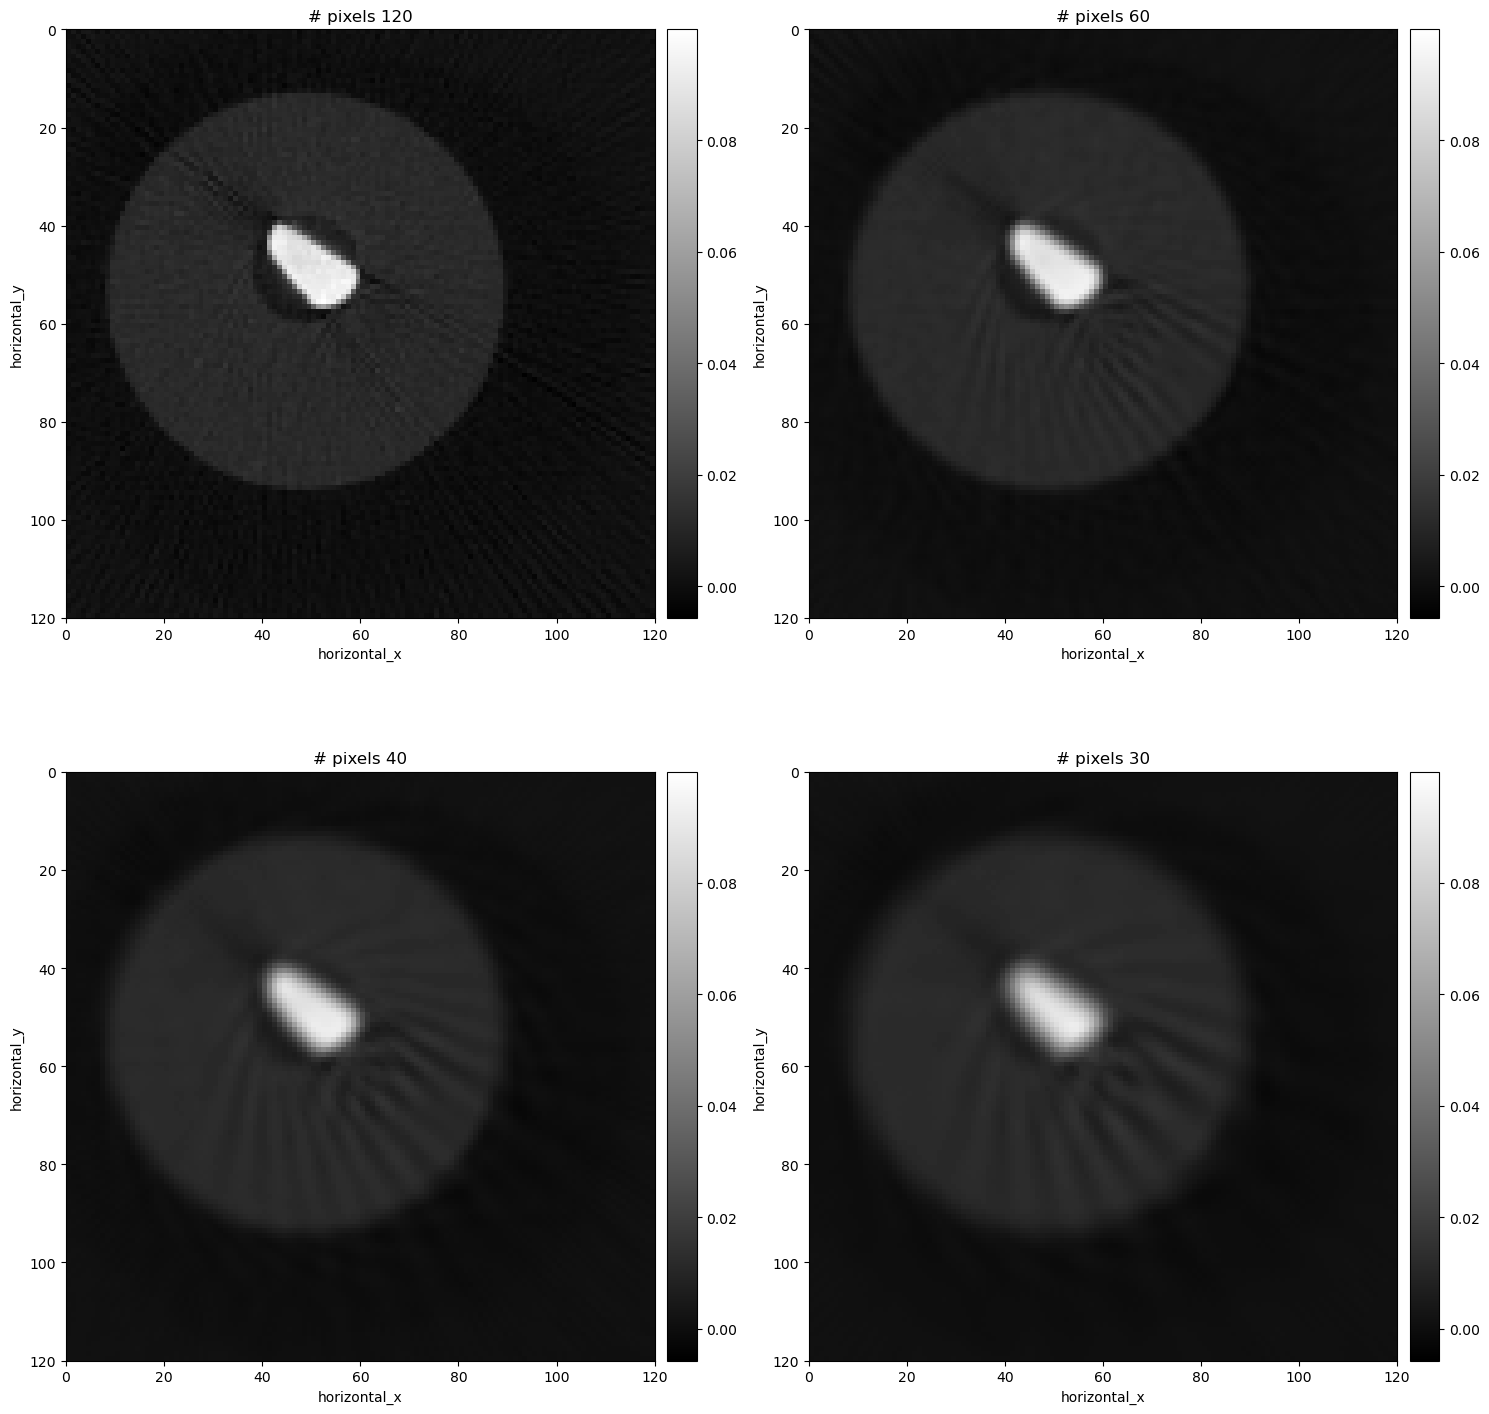

In [33]:
bin_list = [1,2,3,4]
sinograms = []
titles = []
results = []

for bin in bin_list:
   
    #slice acquisition data
    data_binned = Binner(roi={'horizontal': (None, None, bin)})(data_slice)
    sinograms.append(data_binned)
    
    #Perform a fast reconstruction of the slice using FBP
    FBP_output = FBP(ig_slice, data_binned.geometry, device='gpu')(data_binned)

    #save the results
    titles.append("# pixels {}".format(data_binned.shape[1]))
    results.append(FBP_output)

#plot the results    
show2D(results, titles, fix_range=True, cmap=cmap, origin='upper-left')

## Conclusion

In this notebook you learned how to use some basic processors provided by CIL. These processors support basic image manipulations and allow quick design of benchmark studies without manual modification of `AcquisitionGeometry`.

<a id='advanced'></a>
## Advanced: working with bad pixels

Often we have calibrated detector data with the bad pixels corrected before we get the acquisition data. When this isn't the case, or when calibration is not sufficient to remove bad pixels, we can use CIL's `MaskGenerator` and `Masker` to identify outliers and correct them.

We are going to add some bad pixels and columns of bad pixels to our dataset.

The function below will return a new dataset, which is a copy of the input with the addition of `number_of_columns` corrupted columns and `number_of_hot_pix` hot pixels.

In [34]:
def add_bad_pixels(data, number_of_columns, number_of_hot_pix, seed):

    data_corrupted = data.copy()

    # get intensity range
    low = np.amin(data.as_array())
    high = np.amax(data.as_array())

    # we seed random number generator for repeatability
    rng = np.random.RandomState(seed=seed) 
    # indices of bad columns
    columns = rng.randint(0, data.shape[1], size=number_of_columns)
    # indices of hot pixels
    pix_row = rng.randint(0, data.shape[0], size=number_of_hot_pix)
    pix_col = rng.randint(0, data.shape[1], size=number_of_hot_pix)
    # values in hot pixels
    pixel_values = rng.uniform(low=low, high=high, size=number_of_hot_pix)

    for i in range(number_of_columns):
        col_pattern = rng.uniform(low=low, high=high, size=data.shape[0])
        data_corrupted.as_array()[:, columns[i]] = data.as_array()[:, columns[i]]+col_pattern

    for i in range(number_of_hot_pix):
        data_corrupted.as_array()[pix_row[i], pix_col[i]] = pixel_values[i]

    return data_corrupted    

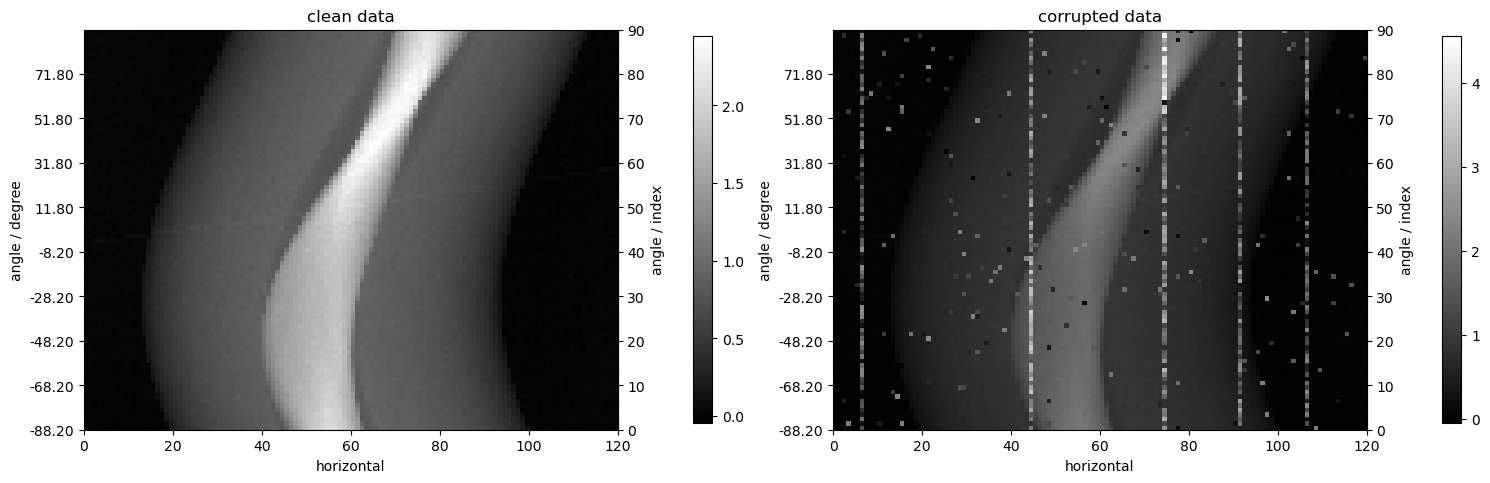

In [35]:
# number of 'bad' columns
number_of_columns = 5
# number of randomly located hot pixels
number_of_hot_pix = 200
# we seed random number generator for repeatability
seed = 8392

data_corrupted = add_bad_pixels(data_slice, number_of_columns, number_of_hot_pix, seed)

show2D([data_slice, data_corrupted], \
        ['clean data', 'corrupted data'], \
        cmap=cmap, num_cols=2, size=(15,10))

Below we show the FBP reconstruction of `corrupted_data` and can see severe artifacts.

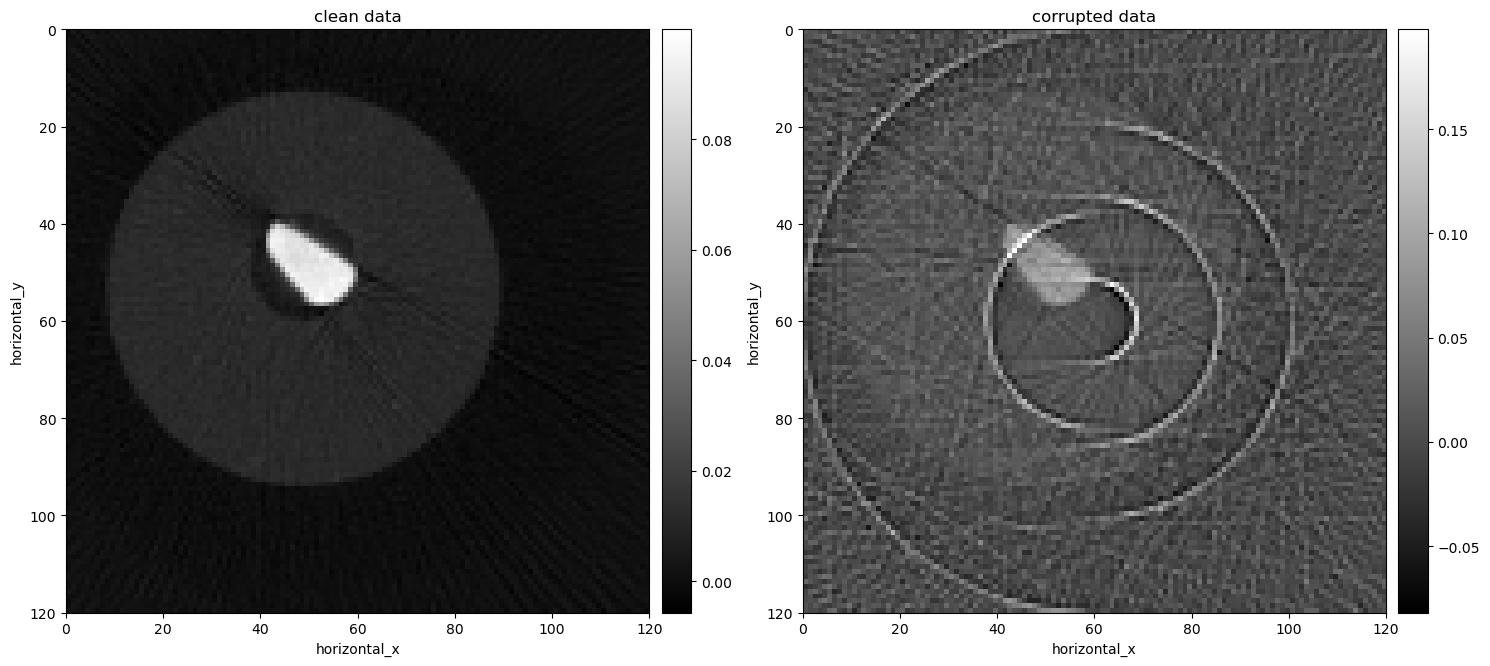

In [36]:
fbp = FBP(ig_slice, data_slice.geometry, device='gpu')
fbp.set_input(data_slice)
fbp_recon_clean = fbp.get_output()  

fbp.set_input(data_corrupted)
fbp_recon_corrupted = fbp.get_output()  

show2D([fbp_recon_clean, fbp_recon_corrupted], \
        ['clean data', 'corrupted data'], \
        cmap=cmap, num_cols=2, size=(15,10), origin='upper-left')

In this case, simple thresholding will not detect all bad pixels. We use `MaskGenerator` with the `median` method, and a moving window of 7 pixels, to detect outliers.

In [37]:
mask = MaskGenerator.median(threshold_factor=3, window=7)(data_corrupted)

`MaskGenerator` returns a binary image which contains 0 where outliers were detected and 1 for other pixels. 
We can look at the generated mask:

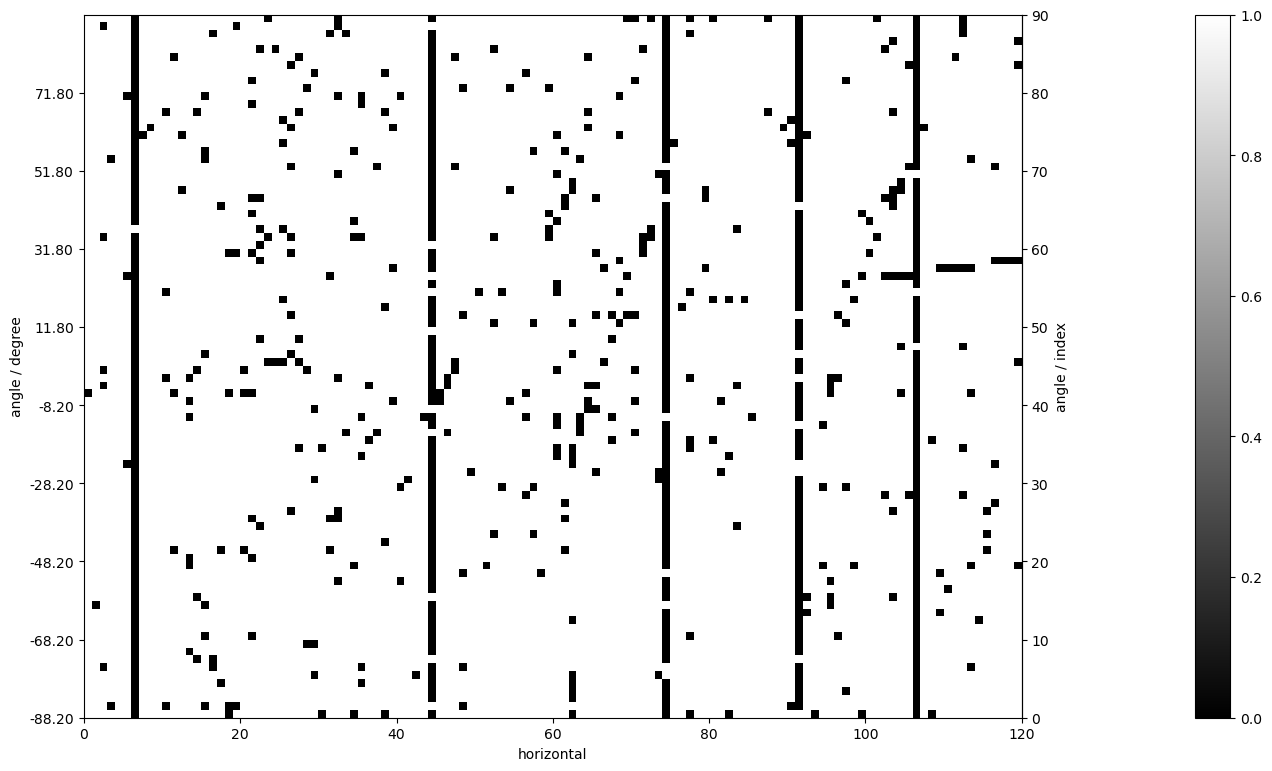

In [38]:
show2D(mask)

Now we have the mask we want to apply it by using `Masker`. We use linear interpolation in this case and pass it the mask.

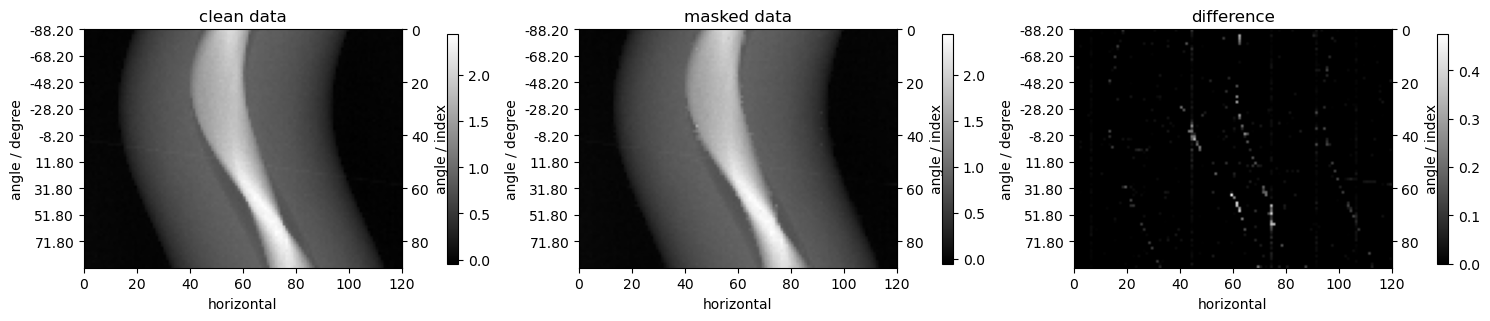

In [39]:
data_masked = Masker.interpolate(mask=mask, method='linear', axis='horizontal')(data_corrupted)

# visualise corrected sinogram
show2D([data_slice, data_masked, (data_slice-data_masked).abs()], \
        ['clean data', 'masked data', 'difference'], \
        cmap=cmap, num_cols=3, size=(15,15), origin='upper-left')

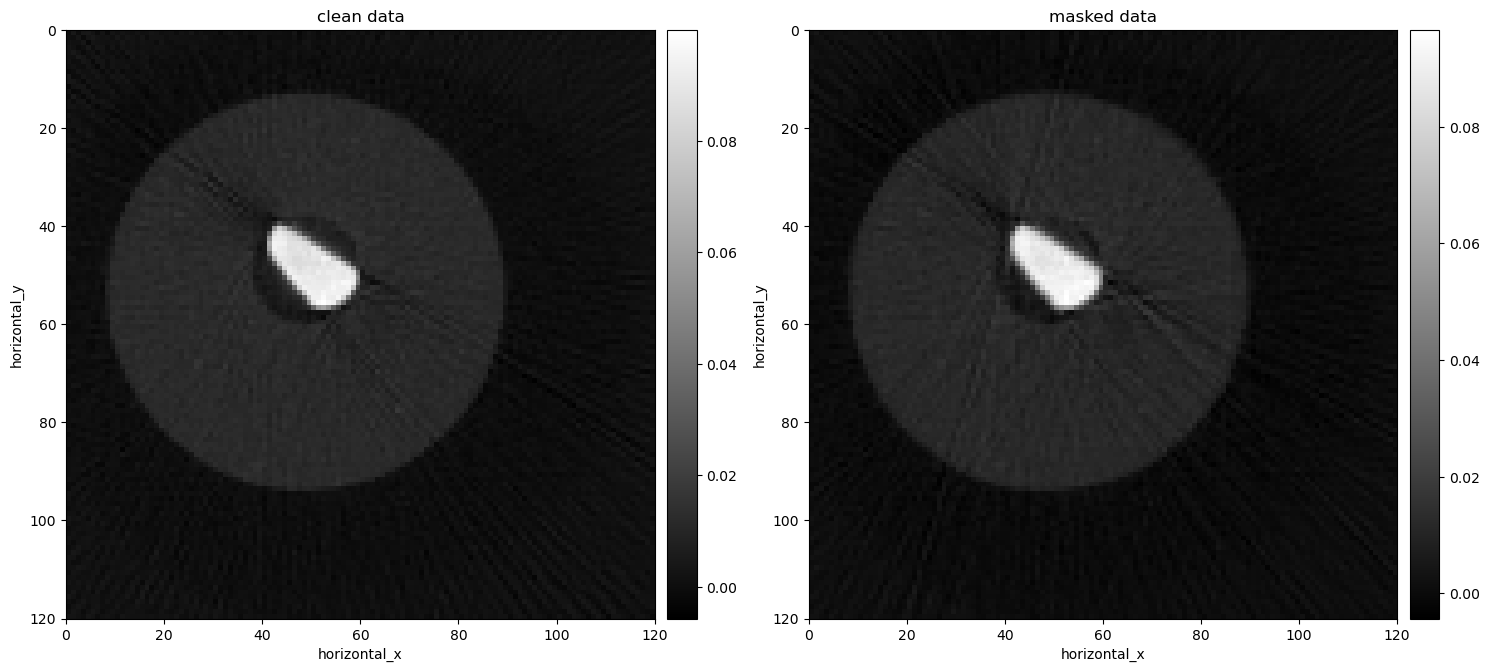

In [40]:
# reconstruct corrected data
fbp.set_input(data_masked)
fbp_recon_masked = fbp.get_output()  

# visualise reconstructions
show2D([fbp_recon_clean, fbp_recon_masked], \
        ['clean data', 'masked data'], \
        cmap=cmap, num_cols=2, size=(15,10), origin='upper-left')